<a href="https://colab.research.google.com/github/roysaumya767-code/CSESA-_PROJECTS/blob/main/ps1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.0MB/s]


In [4]:
image,label=dataset[0]
print('image.shape',image.shape)
image_permuted=image.permute(1,2,0)
image_permuted.shape


image.shape torch.Size([1, 28, 28])


torch.Size([28, 28, 1])

label 5


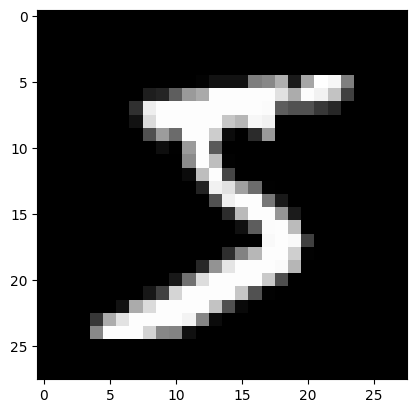

In [5]:
plt.imshow(image_permuted,cmap='gray')
print('label',label)

In [6]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


images.shape torch.Size([128, 1, 28, 28])


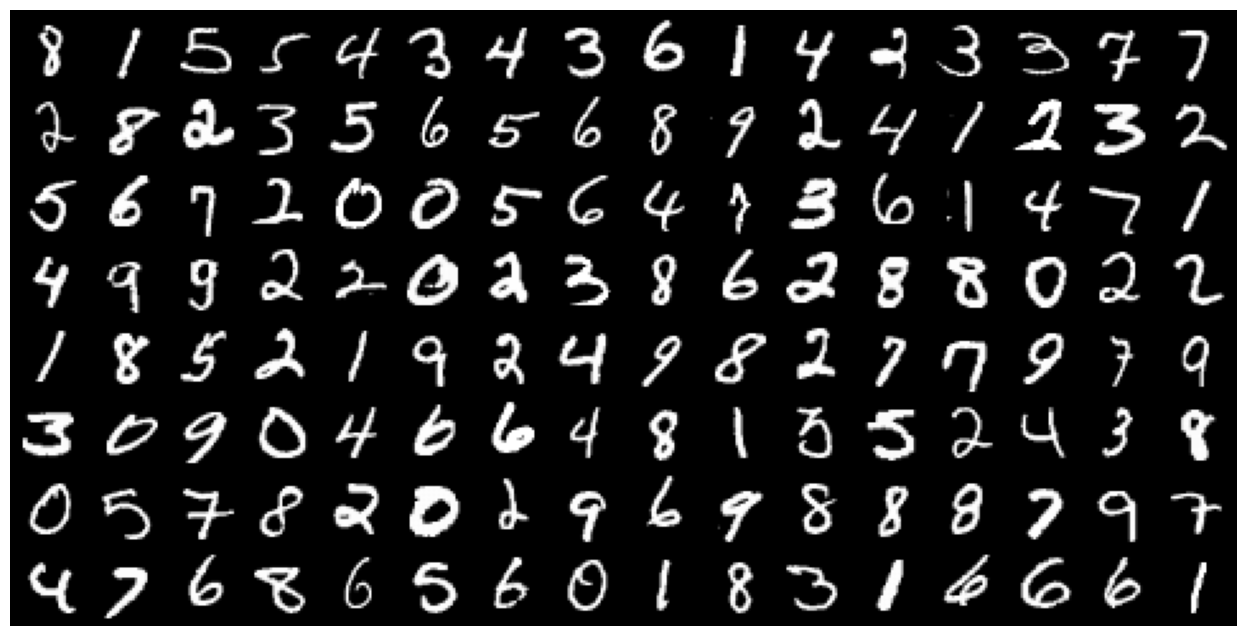

In [7]:
for images, labels in train_loader:
  print('images.shape',images.shape)
  plt.figure(figsize =(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

In [8]:
for images,label in train_loader:
  print(images.shape)
  inputs=images.reshape(-1,784)
  print(inputs.shape)
  break


torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [9]:
input_size=inputs.shape[-1]
hidden_size=32
layer1=nn.Linear(input_size,hidden_size)
layer1_outs=layer1(inputs)
print(layer1_outs.shape)


torch.Size([128, 32])


In [10]:
relu_outputs=F.relu(layer1_outs)
print(torch.min(layer1_outs).item())
print(torch.min(relu_outputs).item())

-0.5979372262954712
0.0


In [11]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)
layer2_outputs=layer2(relu_outputs)

print(layer2_outputs.shape)

torch.Size([128, 10])


In [12]:
class MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    xb=xb.reshape(-1,784)
    out=self.linear1(xb)
    out1=F.relu(out)
    out2=self.linear2(out1)
    return out2
  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc,'batch_size': len(labels)}
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] * x['batch_size'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).sum() / sum([x['batch_size'] for x in outputs])
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).sum() / sum([x['batch_size'] for x in outputs])
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch[{}],val_loss: {:.4f},val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()).float()

In [14]:
input_size=784
hidden_size=32
num_classes=10
model=MnistModel(input_size,hidden_size,num_classes)

In [15]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [16]:
for images,labels in train_loader:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print(loss.item())
  break
print(outputs.shape)
print(outputs[:2].data)


2.312363386154175
torch.Size([128, 10])
tensor([[ 0.1640,  0.2287,  0.0162, -0.0231,  0.2353,  0.0730, -0.1825,  0.0040,
          0.0069,  0.0966],
        [ 0.1640,  0.1137,  0.0140, -0.1197,  0.2264, -0.0531, -0.2114, -0.0727,
          0.0374,  0.1052]])


In [17]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [18]:
device=get_default_device()
device

device(type='cuda')

In [19]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return[to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [20]:
for images,labels in train_loader:
  print(image.shape)
  print(image.device)
  images=to_device(images,device)
  print(images.device)
  break

torch.Size([1, 28, 28])
cpu
cuda:0


In [21]:
torch.cuda.is_available()

True

In [22]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [23]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [24]:
for xb,yb in val_loader:
  print(xb.device)
  print(yb)
  break

cuda:0
tensor([2, 3, 5, 5, 2, 2, 7, 3, 6, 4, 5, 2, 2, 2, 7, 8, 1, 3, 2, 1, 0, 8, 1, 0,
        4, 6, 5, 5, 2, 2, 6, 2, 3, 5, 5, 8, 2, 6, 9, 5, 3, 1, 4, 7, 7, 9, 5, 3,
        8, 0, 5, 5, 3, 0, 9, 0, 2, 8, 8, 7, 6, 9, 8, 4, 4, 1, 0, 1, 5, 2, 8, 6,
        6, 9, 2, 6, 3, 9, 4, 6, 2, 1, 6, 4, 7, 7, 6, 6, 3, 1, 9, 1, 9, 5, 9, 7,
        6, 5, 0, 0, 7, 5, 4, 4, 7, 6, 8, 3, 4, 8, 3, 6, 6, 5, 0, 6, 2, 4, 8, 6,
        9, 1, 2, 2, 9, 5, 7, 1, 8, 8, 3, 0, 5, 8, 7, 3, 0, 9, 7, 2, 2, 7, 1, 2,
        6, 6, 6, 4, 8, 3, 1, 2, 0, 0, 3, 1, 2, 0, 1, 8, 9, 8, 6, 7, 2, 1, 7, 1,
        1, 6, 7, 1, 3, 2, 7, 7, 0, 3, 7, 2, 1, 4, 8, 8, 7, 4, 1, 3, 1, 6, 1, 2,
        9, 0, 8, 5, 3, 1, 7, 2, 6, 7, 9, 1, 4, 1, 1, 0, 5, 0, 7, 4, 8, 2, 9, 8,
        5, 5, 4, 5, 0, 6, 2, 5, 5, 0, 6, 4, 2, 2, 4, 6, 4, 1, 8, 1, 3, 6, 0, 9,
        4, 1, 4, 1, 9, 0, 5, 4, 1, 4, 5, 2, 5, 5, 0, 5], device='cuda:0')


In [25]:
def evalute(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epoch,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  optimizer=opt_func(model.parameters(),lr)
  history=[]
  for epoch in range(epoch):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evalute(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)

  return history

In [26]:
model = MnistModel(input_size, hidden_size, num_classes)
model = to_device(model, device)
history = [evalute(model, val_loader)]
history

[{'val_loss': 2.331559419631958, 'val_acc': 0.0851999968290329}]

In [27]:
history+=fit(5,0.001,model,train_loader,val_loader)

Epoch[0],val_loss: 2.2708,val_acc: 0.1426
Epoch[1],val_loss: 2.2015,val_acc: 0.2650
Epoch[2],val_loss: 2.1227,val_acc: 0.4271
Epoch[3],val_loss: 2.0366,val_acc: 0.4974
Epoch[4],val_loss: 1.9422,val_acc: 0.5528


In [28]:
history+=fit(5,0.01,model,train_loader,val_loader)

Epoch[0],val_loss: 0.9781,val_acc: 0.7880
Epoch[1],val_loss: 0.6518,val_acc: 0.8445
Epoch[2],val_loss: 0.5268,val_acc: 0.8671
Epoch[3],val_loss: 0.4619,val_acc: 0.8829
Epoch[4],val_loss: 0.4241,val_acc: 0.8900


In [29]:
history+=fit(5,0.1,model,train_loader,val_loader)

Epoch[0],val_loss: 0.3219,val_acc: 0.9073
Epoch[1],val_loss: 0.2774,val_acc: 0.9220
Epoch[2],val_loss: 0.2526,val_acc: 0.9291
Epoch[3],val_loss: 0.2372,val_acc: 0.9308
Epoch[4],val_loss: 0.2240,val_acc: 0.9360


In [30]:
history+=fit(5,0.5,model,train_loader,val_loader)

Epoch[0],val_loss: 0.2230,val_acc: 0.9342
Epoch[1],val_loss: 0.1850,val_acc: 0.9450
Epoch[2],val_loss: 0.1425,val_acc: 0.9578
Epoch[3],val_loss: 0.1792,val_acc: 0.9448
Epoch[4],val_loss: 0.1551,val_acc: 0.9548


In [31]:
history+=fit(5,0.5,model,train_loader,val_loader)

Epoch[0],val_loss: 0.1303,val_acc: 0.9617
Epoch[1],val_loss: 0.1563,val_acc: 0.9554
Epoch[2],val_loss: 0.1298,val_acc: 0.9622
Epoch[3],val_loss: 0.1202,val_acc: 0.9654
Epoch[4],val_loss: 0.1300,val_acc: 0.9640


In [32]:
history+=fit(5,0.5,model,train_loader,val_loader)

Epoch[0],val_loss: 0.1275,val_acc: 0.9644
Epoch[1],val_loss: 0.1210,val_acc: 0.9650
Epoch[2],val_loss: 0.1317,val_acc: 0.9660
Epoch[3],val_loss: 0.1587,val_acc: 0.9563
Epoch[4],val_loss: 0.1441,val_acc: 0.9613


In [33]:
history+=fit(5,0.1,model,train_loader,val_loader)

Epoch[0],val_loss: 0.1156,val_acc: 0.9688
Epoch[1],val_loss: 0.1153,val_acc: 0.9690
Epoch[2],val_loss: 0.1161,val_acc: 0.9694
Epoch[3],val_loss: 0.1152,val_acc: 0.9691
Epoch[4],val_loss: 0.1185,val_acc: 0.9684


In [ ]:
history+=fit(5,0.01,model,train_loader,val_loader)

Epoch[0],val_loss: 0.1162,val_acc: 0.9694
Epoch[1],val_loss: 0.1159,val_acc: 0.9694
Epoch[2],val_loss: 0.1157,val_acc: 0.9691
Epoch[3],val_loss: 0.1157,val_acc: 0.9693


In [ ]:
history+=fit(5,0.001,model,train_loader,val_loader)

In [ ]:
history+=fit(5,0.5,model,train_loader,val_loader)

In [ ]:
history+=fit(5,0.001,model,train_loader,val_loader)

In [ ]:
history+=fit(5,0.001,model,train_loader,val_loader)

In [ ]:
losses=[x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs no of epoch')

In [ ]:
test_dataset=MNIST(root='data/',train=False,transform=ToTensor())

In [ ]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds=torch.max(yb,dim=1)
  return preds[0].item()



In [ ]:
img,label=test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('label',label,'predict',predict_image(img,model))

In [ ]:
img,label=test_dataset[1839]
plt.imshow(img[0],cmap='gray')
print('label',label,'predict',predict_image(img,model))

In [ ]:
img,label=test_dataset[193]
plt.imshow(img[0],cmap='gray')
print('label',label,'predict',predict_image(img,model))

In [ ]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size=256),device)
result=evalute(model,test_loader)
result
